# Data exploration Kaggle Speech Recognition

In [1]:
import os.path
from os import listdir
from scipy.io import wavfile
import pyaudio as audio
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
import hashlib
import numpy as np

Defining some constants

In [2]:
# All words to be recognized in the competition
CORE_WORDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 
              'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# Directory name of background noise
BACKGROUND_NOISE = '_background_noise_'
# 'unknown' label
UNKNOWN = 'unknown'
# filename for the .csv with all filepaths for easy import
TRAIN_CSV = 'train.csv'
# filename with all the raw (numerical) data, same ordering as `TRAIN_CSV`
RAW_CSV = 'raw.csv'
# constant for hashing, see `which_set`for more info
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1 # ~134M

Some handy functions

In [3]:
def play(sound, samp_freq=16000):
    """play sound, default samp_freq is 16kHz"""
    p = audio.PyAudio()
    stream = p.open(format = audio.paInt16,    
                    rate = samp_freq,
                    channels = 1,
                    output = True)
    stream.write(sound.tobytes())
    stream.close()
    p.terminate()

def which_set(filename, validation_percentage, testing_percentage): 
    """
    Determines which data partition the file should belong to.
    We want to keep files in the same training, validation, or testing sets even if new ones are added over time. This makes it 
    less likely that testing samples will accidentally be reused in training when long runs are restarted for example. 
    To keep this stability, a hash of the filename is taken and used to determine which set it should belong to. 
    This determination only depends on the name and the set proportions, so it won't change as other files are added.
    It's also useful to associate particular files as related (for example words spoken by the same person), 
    so anything after 'nohash' in a filename is ignored for set determination. 
    This ensures that 'bobby_nohash_0.wav' and 'bobby_nohash_1.wav' are always in the same set, for example.
    
    Args: filename: File path of the data sample. validation_percentage: How much of the data set to use for validation. 
        testing_percentage: How much of the data set to use for testing.
        
    Returns: String, one of 'training', 'validation', or 'testing'. 
    """ 
    base_name = os.path.basename(filename) 
    # We want to ignore anything after 'nohash' in the file name when 
    # deciding which set to put a wav in, so the data set creator has a way of 
    # grouping wavs that are close variations of each other. 
    hash_name = re.sub(r'nohash.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should 
    # go into the training, testing, or validation sets, and we want to keep 
    # existing files in the same set even if more files are subsequently 
    # added. 
    # To do that, we need a stable way of deciding based on just the file name 
    # itself, so we do a hash of that and then use that to generate a 
    # probability value that we use to assign it. 
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest() 
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS)) 
    if percentage_hash < validation_percentage: 
        result = 'validation' 
    elif percentage_hash < (testing_percentage + validation_percentage): 
        result = 'testing' 
    else: result = 'training' 
    return result

def random_sample(df, size=1):
    """
    draw random samples from a dataframe
    """
    return df.loc[np.random.choice(df.index, size, replace=True), :]

def read_wavfile(file_path):
    rate, sound = wavfile.read(file_path)
    timestep = np.arange(0.5/rate, 1, 1./rate)
    return dict(zip(timestep, sound))
    

# Data assemblation
## Filepath training dataframe
Assembling data into a dataframe linking to the path of the soundwaves (which then contains the raw data). The dataframe is exported to `train.csv`.
Columns of `df`:
- `speaker`: the id of the participant speaking in the word
- `word`: the label corresponding to the datapoint (the spoken word)
- `filepath`: path to the .wav file
- `utterance`: sequence id of utterance of the word by that speaker

In [4]:
train_audio_path = os.path.join('train', 'audio')
train_words = [w for w in listdir(train_audio_path) if w != BACKGROUND_NOISE]
dfs = []
columns = ['word', 'filepath']
for w in train_words:
    path = os.path.join(train_audio_path, w)
    sounds = listdir(path)
    #word = w if w in CORE_WORDS else UNKNOWN
    word = w
    records = [(word, os.path.join(path, sound)) for sound in sounds]
    dfs.append(pd.DataFrame.from_records(records, columns=columns))
df = pd.concat(dfs)

In [5]:
df['speaker'] = df['filepath'].str.split('_').str.get(0).str.split('\\').str.get(-1)
df['utterance'] = df['filepath'].str.split('_').str.get(-1).str.split('.').str.get(0)
df = df.sort_values('speaker')
df.to_csv(TRAIN_CSV, index=False)
df.head()

,word,filepath,speaker,utterance
0,bed,train\audio\bed\00176480_nohash_0.wav,00176480,0
1,marvin,train\audio\marvin\00176480_nohash_1.wav,00176480,1
0,marvin,train\audio\marvin\00176480_nohash_0.wav,00176480,0
0,off,train\audio\off\00176480_nohash_0.wav,00176480,0
0,left,train\audio\left\00176480_nohash_0.wav,00176480,0


## Raw data DataFrame

It might be interesting to check some early statistics before actually investigating the waveforms with audio processing analysis

In [6]:
df = pd.read_csv(TRAIN_CSV)
df['word'] = df['word'].astype('category')

### Word distribution

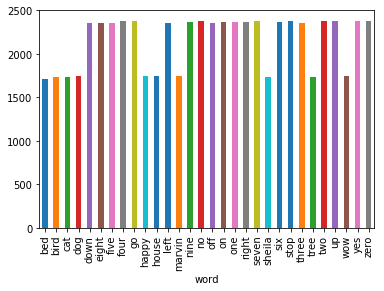

In [7]:
word_count = df.groupby('word')['filepath'].count()
word_count.plot(kind='bar')
plt.show()

All words occur approximately a similar amount of time. Due to this, the `unkown` label is much more represented in the dataset than the rest and somewhat unbalanced which might result to a misleading accuracy later on (*accuracy paradox*). There are three approaches:
- use a logloss as quality measure for the model
- throw data away to achieve a balanced dataset
- learn for all different words at the same time

The last option seems to be the best to me, as we might dodge overfitting with that approach by trying to learn more than we should.
=> change in previous section in code segment `[5]: word = w`.

Some words occur around 1750 times, whilst others are more in the 2400 range. This is a small imbalance which may be perfectly fine.

### Number of speakers

In [8]:
speakers = df['speaker'].unique()
n_speakers = speakers.shape[0]
print(n_speakers)

1881


80% of the speakers will land in the training set, the remaining 20% is for the test set. This ensures an independency between speakers. The same principle will be used for validation later on.

In [9]:
# some old code to split in sets. Not necessary with the which set function
# pivot = int(0.8 * n_speakers)
# df_reindex = df.set_index('speaker')
# df_train = df_reindex.loc[:speakers[pivot], :]
# df_test = df_reindex.loc[speakers[pivot+1]:, :]

df['set'] = df['filepath'].apply(lambda x: which_set(x, 20., 16.))
df.to_csv(TRAIN_CSV, index=False)
df.groupby('set')['speaker'].count()

set
testing       10881
training      40793
validation    13047
Name: speaker, dtype: int64

### Utterances of word by same speaker

Exploring how often words were spoken by the participants

In [10]:
# generates a table counting how much words were spoken by the speakers
df_speaker_word_count = df.pivot_table(values='filepath', index='speaker', columns='word', aggfunc='count', fill_value=0)
df_speaker_word_count.describe()

word,bed,bird,cat,dog,down,eight,five,four,go,happy,...,sheila,six,stop,three,tree,two,up,wow,yes,zero
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,...,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,0.910686,0.920255,0.921318,0.928230,1.254120,1.250399,1.253057,1.261031,1.261031,0.926103,...,0.921850,1.259436,1.265284,1.252525,0.921318,1.261563,1.262626,0.927698,1.263690,1.263158
std,0.904773,0.894439,0.918010,0.888853,1.441507,1.462485,1.456012,1.452956,1.480877,0.926193,...,0.924119,1.479540,1.463859,1.447494,0.940336,1.481681,1.477898,0.929472,1.484532,1.476543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000
max,6.000000,5.000000,5.000000,5.000000,9.000000,9.000000,8.000000,10.000000,10.000000,6.000000,...,6.000000,12.000000,10.000000,10.000000,7.000000,10.000000,10.000000,5.000000,11.000000,10.000000


Some words have been uttered over 10 times. The question is then if it is necessary to keep these different utterations? It might be interesting to listen to these outliers in number of utterances, and if needed throw some data away for balancing out.
Other interesting observations:
- the median is 1 utterance for every word
- the 75% quartile is 1 or 2 for every word
- the 25% quartile is 0 for every word

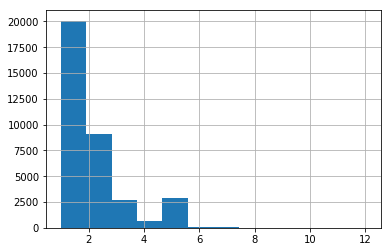

In [11]:
df_speaker_word_count2 = df.groupby(['speaker', 'word'])['filepath'].count()
df_speaker_word_count2.hist(bins=12)
plt.show()

### Retrieving waveforms

Reading in the waveform for every file takes quite some time (1GB). First we read in the samplerate for every file (checking if indeed they all are 16KHz), the raw data is written in a different script: (`script.py`)

In [15]:
df['samplerate'] = df['filepath'].apply(lambda x: wavfile.read(x)[0])

SyntaxError: invalid syntax (<ipython-input-15-2f4410e51832>, line 2)

In [16]:
df['length'] = df['filepath'].apply(lambda x: wavfile.read(x)[1].shape[0])

In [19]:
print(df.groupby('samplerate')['filepath'].count().count())
print(df.groupby('length')['filepath'].count().count())

1
76


All sample rates are 16000KHz, good news. Not all have the 16000 length which would mean they would take 1s. This means we will have to fill NaN values with silence later on.

In [20]:
df.to_csv(TRAIN_CSV)

## Visualization

In [ ]:
rand_w_samples = df.groupby('word', as_index=True).apply(lambda x: random_sample(x, 1)).set_index('word')
#rand_w_samples.loc['bed', 'waveform'].plot()
rand_w_samples.dtypes

In [ ]:
series = df['waveform'].str.strip('[]')
print(series.head())
to_list = lambda x: [-int(d) if d.startswith('-') else int(d) for d in x.split(' ') if d!='']
df['int_waveform'] = series.apply(to_list)
df.head()
df.dtypes

In [ ]:
df.head()

In [ ]:
read_wavfile(df['filepath'][0])
df2 = pd.DataFrame([read_wavfile(row) for row in df['filepath']])

In [ ]:
df3.head()